<a href="https://colab.research.google.com/github/christopherGuan/sample-ds-blog/blob/master/_notebooks/2022-02-01-blog-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amazon Shure MV7 EDA and Sentement Analysis

### Required Packages

[wordcloud](https://github.com/amueller/word_cloud), 
[geopandas](https://geopandas.org/en/stable/getting_started/install.html), 
[nbformat](https://pypi.org/project/nbformat/), 
[seaborn](https://seaborn.pydata.org/installing.html), 
[scikit-learn](https://scikit-learn.org/stable/install.html)

### Now let's get started!
First thing first, you need to load all the necessary libraries:

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import re
import plotly.graph_objects as go
import seaborn as sns

## Read the Data

In [ ]:
#Import Data
df = pd.read_csv("/Users/zeyu/Desktop/DS/Amazon_reviews_scraping/Amazon_reviews_scraping/full_reviews.csv")

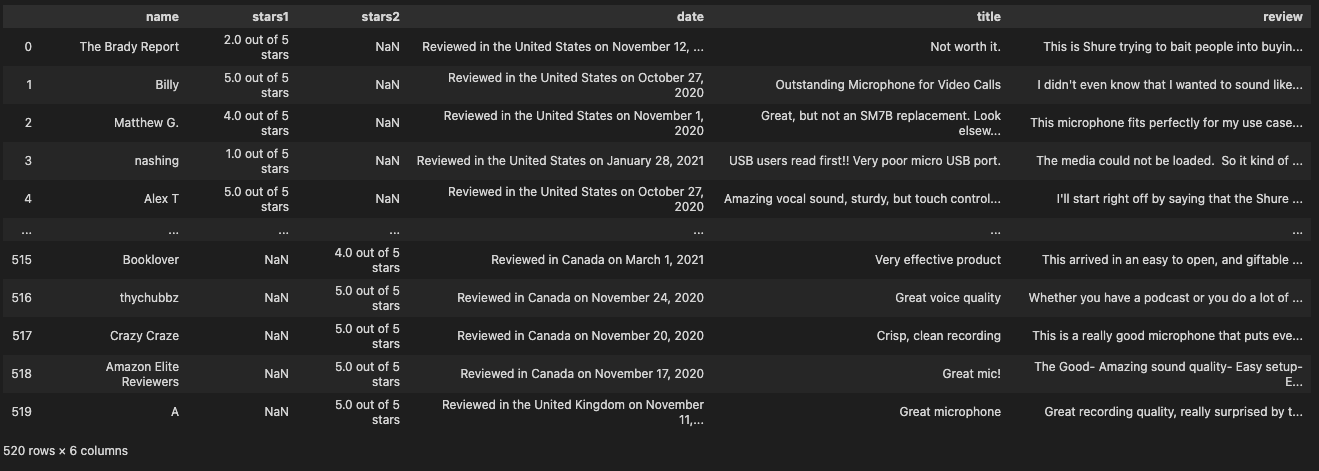

## Data Cleaning

Step 1:
- Splite column Date to Country and Date
- Combine the two rating columns to one
- Convert type of date from string to datetime

In [ ]:
#Clean Data
info = []
for i in df["date"]:
    x = re.sub("Reviewed in ", "", i)
    x1 = re.sub(" on ", "*", x)
    info.append(x1)

df["date"] = pd.DataFrame({"date": info})
df[['country','date']] = df.date.apply(
   lambda x: pd.Series(str(x).split("*")))

star = []
star = df.stars1.combine_first(df.stars2)
df["star"] = pd.DataFrame({"star": star})

del df['stars1']
del df['stars2']

#Convert String to Date
df.date = pd.to_datetime(df.date)

Step 2:
- Two methods to verify if column "star" contain any NaN
- Converted the type of column "star" from string to Int

In [ ]:
"nan" in df['star']

False

In [ ]:
df_no_star = df[df['star'].isna()]
df_no_star

,name,date,title,review,country,star


In [ ]:
#Convert 2.0 out of 5 stars to 2
df_int = []
#df_with_star["stars"] = [str(x).replace(':',' ') for x in df["stars"]]

for i in df["star"]:
    x = re.sub(".0 out of 5 stars", "", i)
    df_int.append(x)

df["rating"] = pd.DataFrame({"rating": df_int})
df["rating"] = df["rating"].astype(int)
del df['star']

This is the data looks like after cleaning.
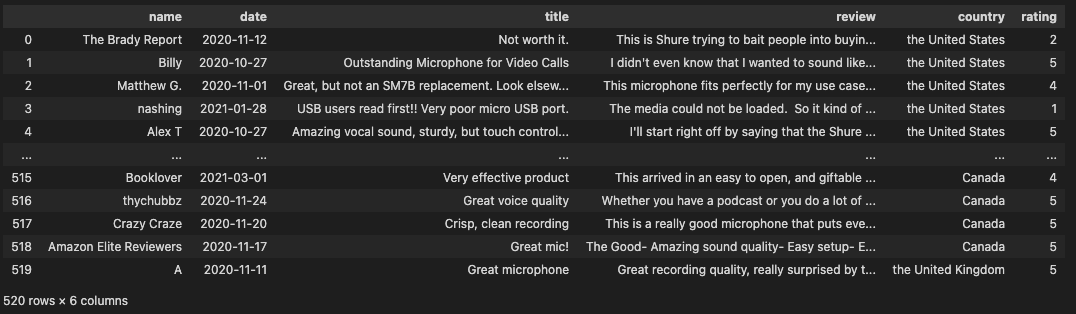

## EDA

In [ ]:
temp = df['rating'].value_counts()
fig = go.Figure(go.Bar(
            x=temp,
            y=temp.index,
            orientation='h'))

fig.show()

In [ ]:
df_country = df['country'].value_counts()
fig = go.Figure(go.Bar(
            x=df_country,
            y=df_country.index,
            orientation='h'))

fig.show()

In [ ]:
mean_rating = df['rating'].mean()
mean_rating

4.446153846153846

In [ ]:
"""fig = px.line(df, x=temp.index, y=temp.rating, title='Life expectancy in Canada')
fig.show()"""
import plotly.express as px
temp = df.groupby([df['date'].dt.date]).mean()
temp

,rating
date,
2020-10-26,5.000000
2020-10-27,5.000000
2020-10-29,5.000000
2020-11-01,4.333333
2020-11-02,5.000000
...,...
2022-01-24,5.000000
2022-01-25,5.000000
2022-01-26,3.000000


<AxesSubplot:xlabel='date'>

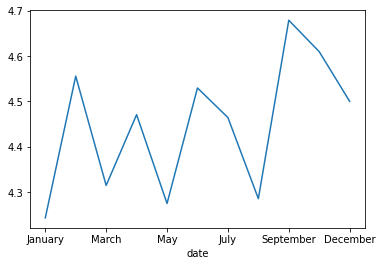

In [ ]:
#Average rating each month
temp = df.groupby(df['date'].dt.strftime('%B'))['rating'].mean().sort_values()
order_temp = temp.reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "November", "December"])
order_temp.plot()

<AxesSubplot:xlabel='date'>

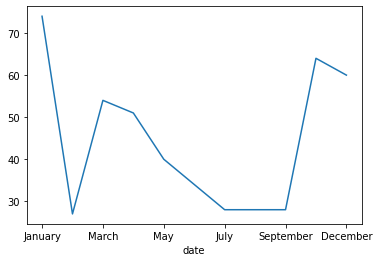

In [ ]:
#Quantity of reviews in each month.
temp = df.groupby(df['date'].dt.strftime('%B'))['rating'].count().sort_values()
order_temp = temp.reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "November", "December"])
order_temp.plot()

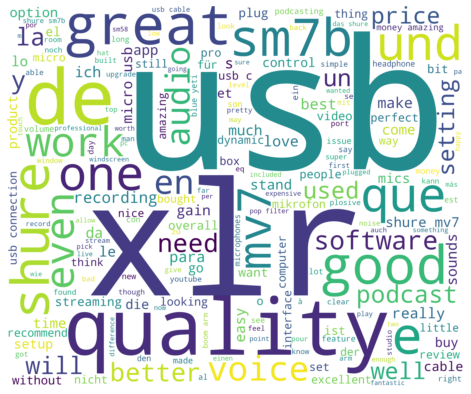

In [ ]:
#Many words are useless so create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(["Mic", "Microphone", "using","sound","use"])


def cleaned_visualise_word_map(x):
    words=" "
    for msg in x:
        msg = str(msg).lower()
        words = words+msg+" "
    wordcloud = WordCloud(stopwords = stopwords, width=3000, height=2500, background_color='white').generate(words)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 14
    fig_size[1] = 7
    #Display image appear more smoothly
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show(wordcloud)
cleaned_visualise_word_map(df["review"])

In [ ]:
df = df[df['rating'] != 3]
df['sentiment'] = df['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [ ]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

In [ ]:
df['sentimentt'] = df['sentiment'].replace({-1 : 'negative'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'positive'})
fig = px.histogram(df, x="sentimentt")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

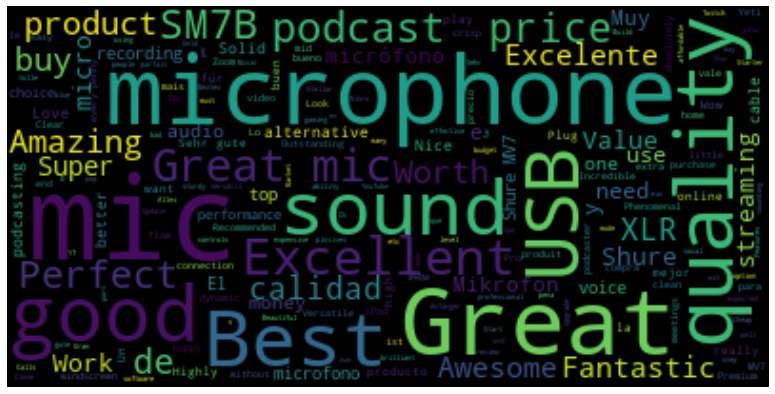

In [ ]:
stopwords = set(STOPWORDS)
#stopwords.update(["Mic", "Microphone", "using","sound","use"]) 

## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.title)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

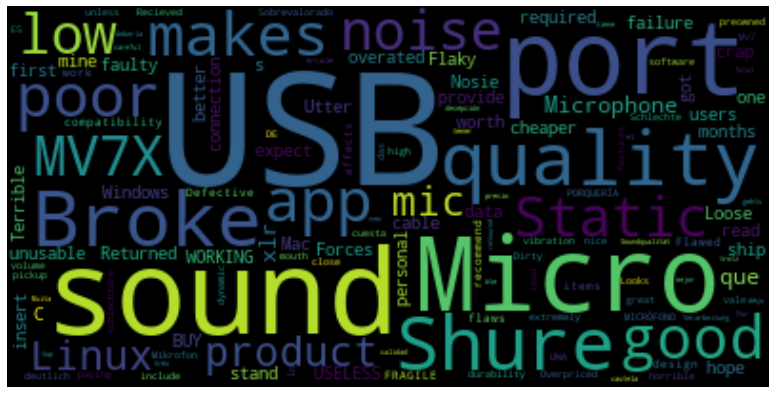

In [ ]:
pos = " ".join(review for review in negative.title)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [ ]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final

df['review'] = df['review'].apply(remove_punctuation)
df = df.dropna(subset=['title'])
df['title'] = df['title'].apply(remove_punctuation)

In [ ]:
dfNew = df[['title','sentiment']]
dfNew.head()

,title,sentiment
0,Not worth it,-1
1,Outstanding Microphone for Video Calls,1
2,"Great, but not an SM7B replacement Look elsewh...",1
3,USB users read first Very poor micro USB port,-1
4,"Amazing vocal sound, sturdy, but touch control...",1


In [ ]:
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['title'])
test_matrix = vectorizer.transform(test['title'])

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [ ]:
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 0,  0],
       [10, 91]])

In [ ]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       101

    accuracy                           0.90       101
   macro avg       0.50      0.45      0.47       101
weighted avg       1.00      0.90      0.95       101



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:

if(prod_name!=" "):
            price = listing.find('span', attrs={'class':"s-item__price"})
            prod_price = str(price.find(text=True, recursive=False))
            x = re.sub("\$", "", prod_price)
            x = x.split(".")
            str_of_price = re.sub((","), "", x[0])
            #x = re.sub("None", np.NaN, str_of_price)
            #print(x)
            #int_of_prices = int(x)
            #x = re.sub("none", "", x)
            #x = re.sub("", "", x)
            #n = int(x)
            prices.append(str_of_price)
"""df_country = df['country'].value_counts()

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:d}".format(pct, absolute)
 

# Creating plot
fig, ax = plt.subplots(figsize =(15, 15))


wedges = plt.pie(df_country, 
        autopct = lambda pct: func(pct, df_country), 
        labels = df_country.index,
        explode = (0.0, 0.0, 0.00, 0.0, 0.0, 0.00, 0.0, 0.05, 0.10, 0.2, 0.2),
        
        )


ax.set_title("Number of Purchase in Countries")

# show plot
plt.show()"""

In [ ]:
"""summarised_results = df_with_star["stars"].value_counts()

fig, ax = plt.subplots(figsize =(8,5))

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=summarised_results.keys(),
    height=summarised_results.values
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Stars', labelpad=15, color='#333333')
ax.set_ylabel('Count', labelpad=15, color='#333333')
ax.set_title('Distribution of Star Ratings', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()"""

In [ ]:
#pd.set_option('display.max_rows', None) Show all Output

#df_with_star = df.mask(df.eq('nan')).dropna() Drop all with nan

#Not efficient way to convert string to number.
"""for i in df['stars']:
    x = i.replace("2.0 out of 5 stars","2")
    x1 = x.replace("3.0 out of 5 stars","3")
    x2 = x1.replace("4.0 out of 5 stars","4")
    x3 = x2.replace("5.0 out of 5 stars","5")
    x4 = x3.replace("1.0 out of 5 stars","1")
    df_int.append(x4)
df_with_star["stars"] = df_int"""

